![numpy logo](https://github.com/numpy/numpy/blob/main/doc/source/_static/numpylogo.svg)

![sla and sss subplots](../images/subplots.png "Image showing two maps of the Western Tropical Atlantic, both with data for the date 2020-09-23. On the left, a map of sea surface height anomaly, and on the right, a map of sea surface salinity.")

<!-- <img src="../images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img> -->

# Data access via earthaccess library and vizualization with cartopy

<!-- In this Notebook, we will access data via the earthaccess python library. Then, we will do some quick visualization to find out the data of interest, to then make informational plots and, if desired, download data.  -->

Issues:
    - authentication - should I create a "dummy" account and leave a .netrc in the nb folder?
    - figures not showing
    - saving data in the end (91K, 47K)
    - is a 360k figure for the top image ok or too large?
    - adjust the environment

---

## Overview

Within this notebook, we will cover:
1. How to search data via Earthdata Search web application
2. How to access NASA Earth Science data via `earthaccess`
3. How to subset, set attributes and modify coordinates for `xarray` Datasets
4. How to visualize data with `hvplot` and `cartopy`
5. How to download data

<!-- Downloading data via Graphical User Interfaces (GUI) can be great for small datasets in isolated instances, but it has a few disadvantages, such as
* it can be tedious - if you have to get data multiple times, repeatedly doing the same task is not a lot of fun, and this time could be better spent
* it is more prone to human error - if you do many times the same task, odds are at some point you will make some mistake
* storage issues - Sometimes it is hard to subset the data via GUI and you're stuck downloading large files when you needed just a small portion of them
* it is not best science reproducibility practice - you can have the source of the data in your documents, but if you can have the actual data access method within the code, that makes it much easier for the work to be reproduced and for other researchers to build upon it

Accessing data programatically, via application programming interface (API), is pretty advantageous when you consider those issues. In this notebook we will present an example of a workflow with access to data via `earthaccess`, a python library for accessing NASA Earth Science data.  -->

## Prerequisites

<!-- In this notebook, we will access some data with the `xarray` library and plot some maps with the `matplotlib` and `cartopy` python libraries. -->

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | Data and metadata structure|
| [netCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Data and metadata structure|
| [Understanding of matplotlib](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Familiarity with plots |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Familiarity with maps|

- **Time to learn**: 30 minutes 

---

## Imports

In [1]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

import earthaccess 
import xarray as xr
import hvplot.xarray
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature

## Sea surface height anomaly

Let's look for some sea surface height anomaly data for the Western Tropical Atlantic. In order to access it, we will use the `earthaccess` python library. It is used to make it easier for the user to find, stream and download NASA Earth Science data. More information about this library can be found in their [documentation page](https://earthaccess.readthedocs.io/en/latest/) and [Github repository](https://github.com/nsidc/earthaccess). Before searching for data, it is necessary to register for an Earthdata login profile, which can be done easily and quickly [this way](https://urs.earthdata.nasa.gov/documentation/for_users/how_to_register).

After registering, earthaccess has to authenticate you as a user. To do that, you have a few ways, as stated [here](https://earthaccess.readthedocs.io/en/latest/user-reference/api/api/#earthaccess.api.login). The easiest way of doing is just executing `auth = earthaccess.login()` in your jupyter notebook, and that would prompt for input of the username and password for the user.

Here we have environment variables that will be used for authentication:

In [2]:
auth = earthaccess.login(strategy="environmnent")

Enter your Earthdata Login username:  apkrelling
Enter your Earthdata password:  ········


After it is authenticated, we are ready to start our search for data!

### Searching and accessing the data

`earthaccess` allows us to look for datasets (called `DataCollections`) and specific data files (called `DataGranules`). To look for them, we need some criteria in order to perform the search. Here we will use 
- a shortname, which is a dataset identifier;
- a temporal window: we want data between those dates; and
- a bounding box: we want data within that area.

One good way to get a better understanding of what to look for is visiting the [Earthdata Search website](https://search.earthdata.nasa.gov/search). There you can search by keywords and select filters to see which data could be helpful in your research. Once you find a dataset (*Collection*) that interest you, you can click on it and click in "Collection Details". After that, you'll be sent to a page that has more information about the dataset. Feel free to read and get details about the dataset, to make sure that's what would help you in your work. If so, get the name, usually all in caps, that is shown inside a light gray box on the top of the page. That is the identifier for that specific dataset. That's the main information we'll need to provide `earthaccess` library to search for it.

![Find Collection](../images/ProjectPythia_Logo_Final-01-Blue.svg)
![Find Collection](https://github.com/ProjectPythia/api-cookbook/tree/main/notebooks/images/earthdata_find_collection.png "Image from the Earthdata Search website showing a list of data collections and the 'MEaSUREsn Gridded Sea Surface Height Anomalies Version 2205' collection highlighted.")

![Collection details](https://github.com/ProjectPythia/api-cookbook/tree/main/notebooks/images/earthdata_collection_details.png "Image from the Earthdata Search website showing a list of granules from the 'MEaSUREsn Gridded Sea Surface Height Anomalies Version 2205' collection, and indicating to click on the 'Collection Details' button on the top right of the screen.")

![Shortname](https://github.com/ProjectPythia/api-cookbook/tree/main/notebooks/images/earthdata_shortname.png "Image from the Earthdata Search website showing the details of the 'MEaSUREs Gridded Sea Surface Height Anomalies Version 2205' data collection, indicating the name 'SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205' as the short name for this particular dataset.")

Now that we have an identifier for the dataset we want to access, let's use `earthaccess` to find sea surface height anomaly data in September and October, 2020, in the Western Tropical Atlantic:

In [3]:
# specify the bounding box for the Western Tropical Atlantic
lonmin, latmin, lonmax, latmax = -70, -5, -45, 20

# https://search.earthdata.nasa.gov/search/granules/collection-details?p=C2270392799-POCLOUD&pg%5B0%5D%5Bv%5D=f&pg%5B0%5D%5Bgsk%5D=-start_date&as%5Bscience_keywords%5D%5B0%5D=Oceans%3ASea%20Surface%20Topography%3ASea%20Level%3ASea%20Level%20Anomaly&tl=1718059227%213%21%21&fsm0=Sea%20Surface%20Topography&fst0=Oceans&fst1=Oceans&fsm1=Sea%20Surface%20Topography&fs11=Sea%20Level&fs21=Sea%20Level%20Anomaly&fpb0=Space-based%20Platforms&long=-0.0703125
sla_shortname = "SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205"

sla_results = earthaccess.search_data(
    short_name=sla_shortname,
    cloud_hosted=True,
    temporal=("2020-09-01", "2020-10-30"),
    bounding_box=(lonmin, latmin, lonmax, latmax)
)

Granules found: 12


<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Note: not all these arguments are necessary, but the more arguments you use, the more refined the search will be. More info 
<a href="https://earthaccess.readthedocs.io/en/latest/user-reference/api/api/#earthaccess.api.search_data">here.</a>
</div>

The function search_data returns a list with the **Granules** found. Here we can think of Granules as files, or time-steps. Great, we found some that match our criteria. Now, let's take a look at one of them:

In [4]:
dict(sla_results[0])

{'meta': {'concept-type': 'granule',
  'concept-id': 'G2546521666-POCLOUD',
  'revision-id': 2,
  'native-id': 'ssh_grids_v2205_2020090312',
  'collection-concept-id': 'C2270392799-POCLOUD',
  'provider-id': 'POCLOUD',
  'format': 'application/vnd.nasa.cmr.umm+json',
  'revision-date': '2023-01-11T00:46:27.402Z'},
 'umm': {'TemporalExtent': {'RangeDateTime': {'EndingDateTime': '2020-09-03T00:00:00.000Z',
    'BeginningDateTime': '2020-09-03T00:00:00.000Z'}},
  'MetadataSpecification': {'URL': 'https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6',
   'Name': 'UMM-G',
   'Version': '1.6.6'},
  'GranuleUR': 'ssh_grids_v2205_2020090312',
  'ProviderDates': [{'Type': 'Insert', 'Date': '2023-01-11T00:46:13.101Z'},
   {'Type': 'Update', 'Date': '2023-01-11T00:46:13.101Z'}],
  'SpatialExtent': {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': 0.083,
       'SouthBoundingCoordinate': -79.917,
       'EastBoundingCoordinate': 180,
       'NorthBoundingCoor

So here we have all the metadata information about this first Granule. You can also check all the Granules from the list, if you'd like to make sure they are all of interest to you:

In [5]:
sla_results 

[Collection: {'Version': '2205', 'ShortName': 'SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': 0.083, 'SouthBoundingCoordinate': -79.917, 'EastBoundingCoordinate': 180, 'NorthBoundingCoordinate': 79.917}, {'WestBoundingCoordinate': -180, 'SouthBoundingCoordinate': -79.917, 'EastBoundingCoordinate': -0.083, 'NorthBoundingCoordinate': 79.917}]}}}
 Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2020-09-03T00:00:00.000Z', 'BeginningDateTime': '2020-09-03T00:00:00.000Z'}}
 Size(MB): 9.234445571899414
 Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205/ssh_grids_v2205_2020090312.nc'],
 Collection: {'Version': '2205', 'ShortName': 'SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles':

OK, we found some results that interest us. Now let's access them!

Two possibly important limiting factors for research are limited computing capacity and limited data storage. Even if data storage is not very limited, unecessarily working with large files is not best practice. So here we'll not download the data; we'll stream it instead, using xarray. Through xarray we can take a look at the data, subset, perform some analyses and, only if we are certain that we want to look further into it, download the data.

So let's start by opening the data Granules as a dataset with xarray. This can take some time, depending on your system.

In [6]:
%%time 
sla_ds = xr.open_mfdataset(earthaccess.open(sla_results))
sla_ds

Opening 12 granules, approx size: 0.11 GB


QUEUEING TASKS | : 100%|██████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 713.34it/s]
PROCESSING TASKS | : 100%|█████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.58it/s]
COLLECTING RESULTS | : 100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 39260.26it/s]


CPU times: user 3.91 s, sys: 479 ms, total: 4.39 s
Wall time: 54.4 s


<xarray.Dataset> Size: 199MB
Dimensions:      (Time: 12, Longitude: 2160, nv: 2, Latitude: 960)
Coordinates:
  * Longitude    (Longitude) float32 9kB 0.08333 0.25 0.4167 ... 359.8 359.9
  * Latitude     (Latitude) float32 4kB -79.92 -79.75 -79.58 ... 79.75 79.92
  * Time         (Time) datetime64[ns] 96B 2020-09-03T12:00:00 ... 2020-10-28...
Dimensions without coordinates: nv
Data variables:
    Lon_bounds   (Time, Longitude, nv) float32 207kB dask.array<chunksize=(1, 2160, 2), meta=np.ndarray>
    Lat_bounds   (Time, Latitude, nv) float32 92kB dask.array<chunksize=(1, 960, 2), meta=np.ndarray>
    Time_bounds  (Time, nv) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    SLA          (Time, Latitude, Longitude) float32 100MB dask.array<chunksize=(1, 960, 2160), meta=np.ndarray>
    SLA_ERR      (Time, Latitude, Longitude) float32 100MB dask.array<chunksize=(1, 960, 2160), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.6
    ncei_template_version:  NCEI_NetCDF_Grid_Template_v2.0
    Institution:            Jet Propulsion Laboratory
    geospatial_lat_min:     -79.916664
    geospatial_lat_max:     79.916664
    geospatial_lon_min:     0.083333336
    ...                     ...
    version_number:         2205
    Data_Pnts_Each_Sat:     {"16": 728440, "1007": 702669}
    source_version:         commit ad8fdfbffc5581946ae8e9ea13699e2d6dcadba9
    SLA_Global_MEAN:        0.06743581712198123
    SLA_Global_STD:         0.09305447947672979
    latency:                final

### Subsetting the data, adjusting the coordinates and assigning attributes

If we take a look at the loaded dataset, we notice a few things:
   * The search yielded 12 granules, so we have 12 time-steps in the resulting dataset
   * The `Latitude` and `Longitude` span a much greater area than requested in the search. The dataset loaded contains the area that we requested, plus much more.
   * we have a few data variables besides `SLA` (Sea Level Anomaly Estimate)
   * the `Longitude` coordinate goes from 0 to 360 instead of from -180 to 180.
   * there are multiple attributes. Those are very important, since they contain dataset metadata information.
   
That being said, we need to do a few things to make this dataset ready for analysis, visualization, and/or download.

The first thing to do is to adjust the `Longitude` coordinates and sort the data accordingly:

In [7]:
# convert Longitude from 0-360 to -180-180
sla_ds.coords['Longitude'] = (sla_ds.coords['Longitude'] + 180) % 360 - 180
sla_ds = sla_ds.sortby(sla_ds.Longitude)
sla_ds

<xarray.Dataset> Size: 199MB
Dimensions:      (Time: 12, Longitude: 2160, nv: 2, Latitude: 960)
Coordinates:
  * Latitude     (Latitude) float32 4kB -79.92 -79.75 -79.58 ... 79.75 79.92
  * Time         (Time) datetime64[ns] 96B 2020-09-03T12:00:00 ... 2020-10-28...
  * Longitude    (Longitude) float32 9kB -179.9 -179.8 -179.6 ... 179.8 179.9
Dimensions without coordinates: nv
Data variables:
    Lon_bounds   (Time, Longitude, nv) float32 207kB dask.array<chunksize=(1, 2160, 2), meta=np.ndarray>
    Lat_bounds   (Time, Latitude, nv) float32 92kB dask.array<chunksize=(1, 960, 2), meta=np.ndarray>
    Time_bounds  (Time, nv) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    SLA          (Time, Latitude, Longitude) float32 100MB dask.array<chunksize=(1, 960, 2160), meta=np.ndarray>
    SLA_ERR      (Time, Latitude, Longitude) float32 100MB dask.array<chunksize=(1, 960, 2160), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.6
    ncei_template_version:  NCEI_NetCDF_Grid_Template_v2.0
    Institution:            Jet Propulsion Laboratory
    geospatial_lat_min:     -79.916664
    geospatial_lat_max:     79.916664
    geospatial_lon_min:     0.083333336
    ...                     ...
    version_number:         2205
    Data_Pnts_Each_Sat:     {"16": 728440, "1007": 702669}
    source_version:         commit ad8fdfbffc5581946ae8e9ea13699e2d6dcadba9
    SLA_Global_MEAN:        0.06743581712198123
    SLA_Global_STD:         0.09305447947672979
    latency:                final

Now we can see that the dataset has Longitude values between -180 and 180. Great!

The next step is to subset the data - we don't need SLA for the entire globe, just for the Western Tropical Atlantic, so there's no need to be messing with large files. To subset the data, we leverage the power of slicing in xarray:

In [8]:
sla_subset = sla_ds['SLA'].sel(Latitude=slice(latmin, latmax), Longitude=slice(lonmin,lonmax))
sla_subset

<xarray.DataArray 'SLA' (Time: 12, Latitude: 150, Longitude: 150)> Size: 1MB
dask.array<getitem, shape=(12, 150, 150), dtype=float32, chunksize=(1, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * Latitude   (Latitude) float32 600B -4.917 -4.75 -4.583 ... 19.58 19.75 19.92
  * Time       (Time) datetime64[ns] 96B 2020-09-03T12:00:00 ... 2020-10-28T1...
  * Longitude  (Longitude) float32 600B -69.92 -69.75 -69.58 ... -45.25 -45.08
Attributes:
    units:          m
    long_name:      Sea Level Anomaly Estimate
    standard_name:  sea_surface_height_above_sea_level
    alias:          sea_surface_height_above_sea_level

This looks better, but in order for this to be the main object of analysis and for us to be able to delete the original dataset (spanning the entire global ocean), we need to make sure it has metadata information. In order to do that, we gather some attributes from the original dataset, remove the ones that don't make sense after subsetting, and assign these attributes to the sla_subset DataArray:

In [9]:
# get attributes from the original Dataset
sla_attrs = sla_ds.attrs
del sla_ds

# remove some attributes
attrs_to_be_removed = ['geospatial_lat_min', 
                       'geospatial_lat_max', 
                       'geospatial_lon_min', 
                       'geospatial_lon_max', 
                       'time_coverage_start', 
                       'time_coverage_end']
for attr in attrs_to_be_removed:
    del sla_attrs[attr]
    
# assign attributes to DataArray    
sla_subset = sla_subset.assign_attrs(sla_attrs)

# check that the new attributes are there
sla_subset.attrs

{'units': 'm',
 'long_name': 'MEaSUREs Gridded Sea Surface Height Anomalies Version 2205',
 'standard_name': 'sea_surface_height_above_sea_level',
 'alias': 'sea_surface_height_above_sea_level',
 'Conventions': 'CF-1.6',
 'ncei_template_version': 'NCEI_NetCDF_Grid_Template_v2.0',
 'Institution': 'Jet Propulsion Laboratory',
 'date_created': '2022-10-30T20:57:45.862149',
 'title': 'Sea Level Anomaly Estimate based on Altimeter Data, final product (replaced interim version).',
 'short_name': 'SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205',
 'summary': 'Sea level anomaly grids from altimeter data using Kriging interpolation, which gives best linear prediction based upon prior knowledge of covariance. ',
 'DOI': '10.5067/SLREF-CDRV3',
 'version_number': '2205',
 'Data_Pnts_Each_Sat': '{"16": 728440, "1007": 702669}',
 'source_version': 'commit ad8fdfbffc5581946ae8e9ea13699e2d6dcadba9',
 'SLA_Global_MEAN': 0.06743581712198123,
 'SLA_Global_STD': 0.09305447947672979,
 'latency'

Great, now that we have data and metadata. Now, let's take a quick look at the data for the few time-steps that we have loaded and see if they show any interesting feature for us to investigate further. We can do that easily and interactively with hvplot:

In [10]:
sla_subset.hvplot.image(x='Longitude', y='Latitude', aspect="equal", cmap='RdBu_r', clim=(-0.4, 0.4), title="Sea Level Anomaly Estimate (m)")

:DynamicMap   [Time]
   :Image   [Longitude,Latitude]   (MEaSUREs Gridded Sea Surface Height Anomalies Version 2205)

After inspection, we decide that the data for Sept 23rd, 2020 looks promising. So let's subset further, to have just this time-step in our DataArray:

In [11]:
date_selection = '2020-09-23' 
sla_subset_plot = sla_subset.sel(Time=date_selection)
del sla_subset
sla_subset_plot

<xarray.DataArray 'SLA' (Time: 1, Latitude: 150, Longitude: 150)> Size: 90kB
dask.array<getitem, shape=(1, 150, 150), dtype=float32, chunksize=(1, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * Latitude   (Latitude) float32 600B -4.917 -4.75 -4.583 ... 19.58 19.75 19.92
  * Time       (Time) datetime64[ns] 8B 2020-09-23T12:00:00
  * Longitude  (Longitude) float32 600B -69.92 -69.75 -69.58 ... -45.25 -45.08
Attributes: (12/18)
    units:                  m
    long_name:              MEaSUREs Gridded Sea Surface Height Anomalies Ver...
    standard_name:          sea_surface_height_above_sea_level
    alias:                  sea_surface_height_above_sea_level
    Conventions:            CF-1.6
    ncei_template_version:  NCEI_NetCDF_Grid_Template_v2.0
    ...                     ...
    version_number:         2205
    Data_Pnts_Each_Sat:     {"16": 728440, "1007": 702669}
    source_version:         commit ad8fdfbffc5581946ae8e9ea13699e2d6dcadba9
    SLA_Global_MEAN:        0.06743581712198123
    SLA_Global_STD:         0.09305447947672979
    latency:                final

Note that the subsetted DataArray has all the attributes that we have assigned from the original dataset.

### Sea Surface height anomaly visualization

Now let's make a more ellaborate visualization of the data to analyze the features better. For that, we will use the library `cartopy`.

<a list of 27 text.Text objects>

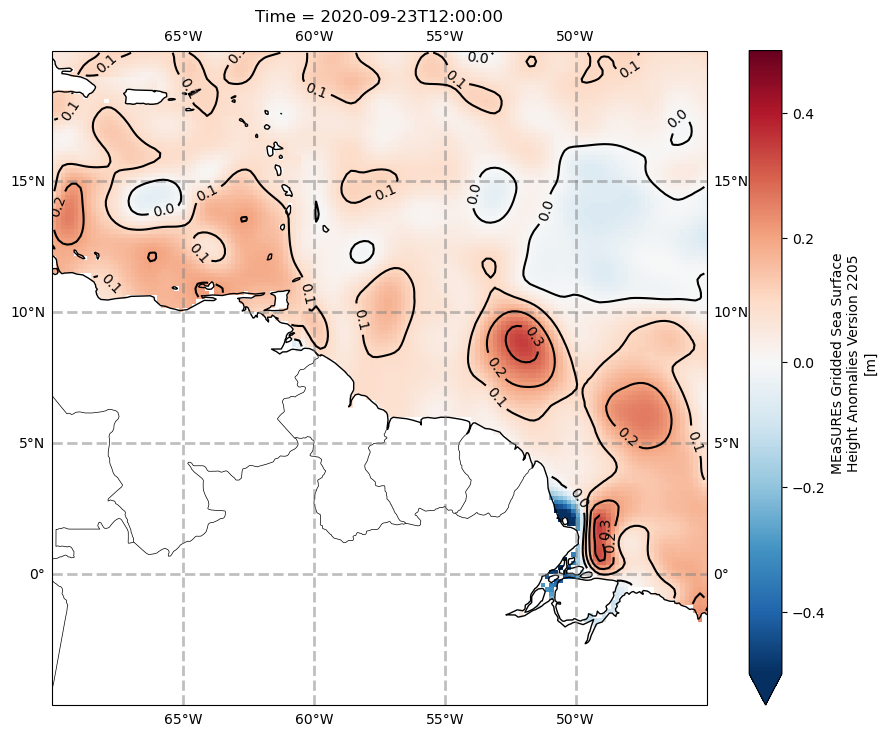

In [12]:
# initialize figure
fig = plt.figure(figsize=(11, 8.5))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

# add features to map
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
gl = ax.gridlines(
    draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--'
)
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())

# plot data
levs = np.linspace(0,0.5,6)
fmt = '%1.1f'
sla_subset_plot.plot(vmin=-0.5, vmax=0.5, cmap ='RdBu_r', transform=ccrs.PlateCarree())
cs = sla_subset_plot.squeeze().plot.contour(levels=levs,colors='k')
ax.clabel(cs, levs, fmt=fmt, inline=True, fontsize=10)

The colorbar centered in zero helps us understand the data better. The main features are in the eastern part, where close to the coast we can see strong gradients, but altimetry data too close to the coast might have some issues. So we focus on the features further from the coast, and the main ones we see are circular contour lines between 5°N and 10°N, and 45°W and 55°W. Some knowledge of the ocean circulation patterns in the area suggest that these features are associated with the North Brazil Current retroflection and a North Brazil Current Ring. Can we see any signature of that in salinity? Let's check!

### Sea surface salinity data

### Searching and accessing the data

Similarly to what was done for sea surface height anomaly, we'll visit the  [Earthdata Search website](https://search.earthdata.nasa.gov/search) to see what salinity data is available for the region and the time-period we're interested. After some search, we find that the dataset with the shortname "SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5" seems applicable, even though it's an 8-day mean. Let's set the same bounding box, the time span for around the same day we analyzed for sea surface height anomaly, and see what data is available:

In [13]:
# https://search.earthdata.nasa.gov/search/granules/collection-details?p=C2208425700-POCLOUD&pg%5B0%5D%5Bv%5D=f&pg%5B0%5D%5Bqt%5D=2021-09-01%2C2021-11-30&pg%5B0%5D%5Bgsk%5D=-start_date&tl=1718241606.658%213%21%21
sss_dataname="SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5"

sss_results = earthaccess.search_data(
    short_name=sss_dataname,
    cloud_hosted=True,
    temporal=("2020-09-23","2020-09-24"), # considering salt_results = salt_results[::3], the second time-step is the best for showing a ring and comparing to altimetry
    bounding_box=(lonmin, latmin, lonmax, latmax)
)

Granules found: 9


We notice that there were 9 granules for the time span between 2020-09-23 and 2020-09-24, which seems excessive. Let's take a look at some of the granules:

In [14]:
sss_results[0:3]

[Collection: {'Version': '5.0', 'ShortName': 'SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': 0.125, 'SouthBoundingCoordinate': -89.875, 'EastBoundingCoordinate': 180, 'NorthBoundingCoordinate': 89.875}, {'WestBoundingCoordinate': -180, 'SouthBoundingCoordinate': -89.875, 'EastBoundingCoordinate': -0.125, 'NorthBoundingCoordinate': 89.875}]}}}
 Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2020-09-23T12:00:00.000Z', 'BeginningDateTime': '2020-09-15T12:00:00.000Z'}}
 Size(MB): 46.519227027893066
 Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2020_263_FNL_v05.0.nc'],
 Collection: {'Version': '5.0', 'ShortName': 'SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': 0.125, 'Sou

Looking at the EndingDateTime and BeginningDateTime for each granule, we conclude that `earthaccess` found all the granules in which the date 2020-09-23 and/or 2020-09-24 were used to calculate the 8-day mean, and that's why there are so many granules. 

Let's load the dataset:

In [15]:
%%time
sss_ds = xr.open_mfdataset(earthaccess.open(sss_results))

Opening 9 granules, approx size: 0.41 GB


QUEUEING TASKS | : 100%|███████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 2414.84it/s]
PROCESSING TASKS | : 100%|███████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.39it/s]
COLLECTING RESULTS | : 100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 35780.79it/s]


CPU times: user 2.65 s, sys: 238 ms, total: 2.89 s
Wall time: 32.5 s


In this dataset we see many of the same issues we saw in the sea surface height anomaly dataset:
* large area, much bigger than the bouding box
* other data variables besides sea surface salinity
* longitude between 0 and 360 instead of -180 and 180
* multiple attributes - that's a good thing!

### Subsetting the data, adjusting the coordinates and assigning attributes

Now we need to adjust this dataset, very similarly to what we did for the sea surface height anomaly one. First, we convert the longitude coordinates and sort the data accordingly:

In [16]:
sss_ds.coords['lon'] = (sss_ds.coords['lon'] + 180) % 360 - 180
sss_ds = sss_ds.sortby(sss_ds.lon)
sss_ds

<xarray.Dataset> Size: 1GB
Dimensions:                 (time: 9, lat: 720, lon: 1440,
                             uncertainty_components: 9, iceflag_components: 3)
Coordinates:
  * lat                     (lat) float32 3kB -89.88 -89.62 ... 89.62 89.88
  * time                    (time) datetime64[ns] 72B 2020-09-19T12:00:00 ......
  * lon                     (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
Dimensions without coordinates: uncertainty_components, iceflag_components
Data variables: (12/19)
    nobs                    (time, lat, lon) float64 75MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs_RF                 (time, lat, lon) float64 75MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs_40km               (time, lat, lon) float64 75MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap                (time, lat, lon) float32 37MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap_RF             (time, lat, lon) float32 37MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap_unc            (time, lat, lon) float32 37MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...                      ...
    fland                   (time, lat, lon) float32 37MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    gice_est                (time, lat, lon) float32 37MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    surtep                  (time, lat, lon) float32 37MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    winspd                  (time, lat, lon) float32 37MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sea_ice_zones           (time, lat, lon) int8 9MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    anc_sea_ice_flag        (time, lat, lon, iceflag_components) int8 28MB dask.array<chunksize=(1, 720, 1440, 2), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                                            CF-1.7, ACDD-1.3
    title:                                                  SMAP ocean surfac...
    version:                                                V5.0 Validated Re...
    summary:                                                The dataset conta...
    acknowledgement:                                        Funded under Subc...
    processing_level:                                       L3
    ...                                                     ...
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    Source_of_ancillary_reference_SSS_from_HYCOM:           Hybrid Coordinate...

Then we subset just for the variable we want, for the area within the bounding box, and make sure to assign most attributes from the original dataset:

In [17]:
# geographically subset
sss_subset = sss_ds['sss_smap_40km'].sel(lat=slice(latmin, latmax), lon=slice(lonmin,lonmax))

# get attributes from original dataset
sss_attrs = sss_ds.attrs
del sss_ds

# remove attributes that don't apply
attrs_to_be_removed = ['center_day_of_observation',
                      'first_orbit',
                      'last_orbit',
                      'geospatial_lat_min', 
                      'geospatial_lat_max', 
                      'geospatial_lon_min', 
                      'geospatial_lon_max', 
                      'time_coverage_start', 
                      'time_coverage_end']
for attr in attrs_to_be_removed:
    del sss_attrs[attr]
    
sss_subset = sss_subset.assign_attrs(sss_attrs)
sss_subset

<xarray.DataArray 'sss_smap_40km' (time: 9, lat: 100, lon: 100)> Size: 360kB
dask.array<getitem, shape=(9, 100, 100), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 400B -4.875 -4.625 -4.375 ... 19.38 19.62 19.88
  * time     (time) datetime64[ns] 72B 2020-09-19T12:00:00 ... 2020-09-27T12:...
  * lon      (lon) float32 400B -69.88 -69.62 -69.38 ... -45.62 -45.38 -45.12
Attributes: (12/62)
    long_name:                                              SMAP sea surface ...
    standard_name:                                          sea_surface_salinity
    units:                                                  1e-3
    valid_min:                                              0.0
    valid_max:                                              45.0
    coverage_content_type:                                  physicalMeasurement
    ...                                                     ...
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    Source_of_ancillary_reference_SSS_from_HYCOM:           Hybrid Coordinate...

Now we need to choose a time-step. If we look at the coordinates "time", we'll notice that the days in it are the center days of the running mean. So we'll just pick the same day used for the sea surface height anomaly data, '2020-09-23':

In [18]:
date_selection = '2020-09-23'
sss_subset_plot = sss_subset.sel(time=date_selection)
del sss_subset

sss_subset_plot

<xarray.DataArray 'sss_smap_40km' (time: 1, lat: 100, lon: 100)> Size: 40kB
dask.array<getitem, shape=(1, 100, 100), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 400B -4.875 -4.625 -4.375 ... 19.38 19.62 19.88
  * time     (time) datetime64[ns] 8B 2020-09-23T12:00:00
  * lon      (lon) float32 400B -69.88 -69.62 -69.38 ... -45.62 -45.38 -45.12
Attributes: (12/62)
    long_name:                                              SMAP sea surface ...
    standard_name:                                          sea_surface_salinity
    units:                                                  1e-3
    valid_min:                                              0.0
    valid_max:                                              45.0
    coverage_content_type:                                  physicalMeasurement
    ...                                                     ...
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    Source_of_ancillary_reference_SSS_from_HYCOM:           Hybrid Coordinate...

### Sea Surface height anomaly visualization

Great, we got a DataArray with just one time-step; now let's plot a map of it:

<a list of 57 text.Text objects>

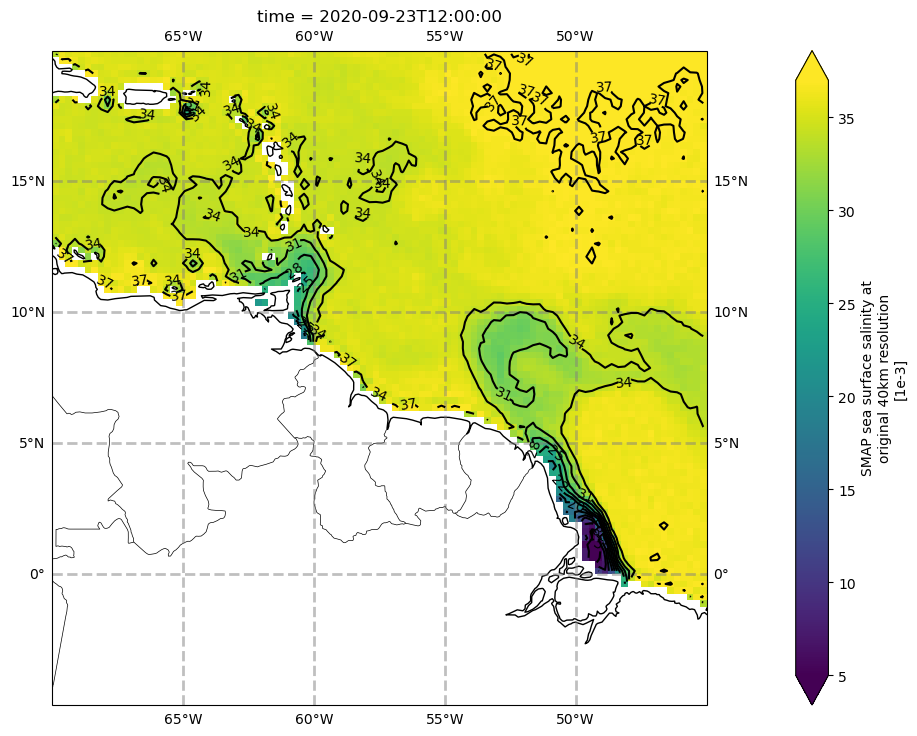

In [19]:
# initialize the figure
fig = plt.figure(figsize=(23, 8.5))

# add features to map
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
gl = ax.gridlines(
    draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--'
)
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())

# plot data
levs_sss = np.linspace(5,37,12)
fmt_sss = '%1.0f'
sss_subset_plot.plot(vmin=5, vmax=37, transform=ccrs.PlateCarree())
cs = sss_subset_plot.squeeze().plot.contour(levels=levs_sss,colors='k')
ax.clabel(cs, levs_sss, fmt=fmt_sss, inline=True, fontsize=10)


The sea surface salinity map seems good, but if we put the plots next to each other, we could have a better understanding of what's going on.

## Sea surface height anomaly and sea surface salinity combined visualization

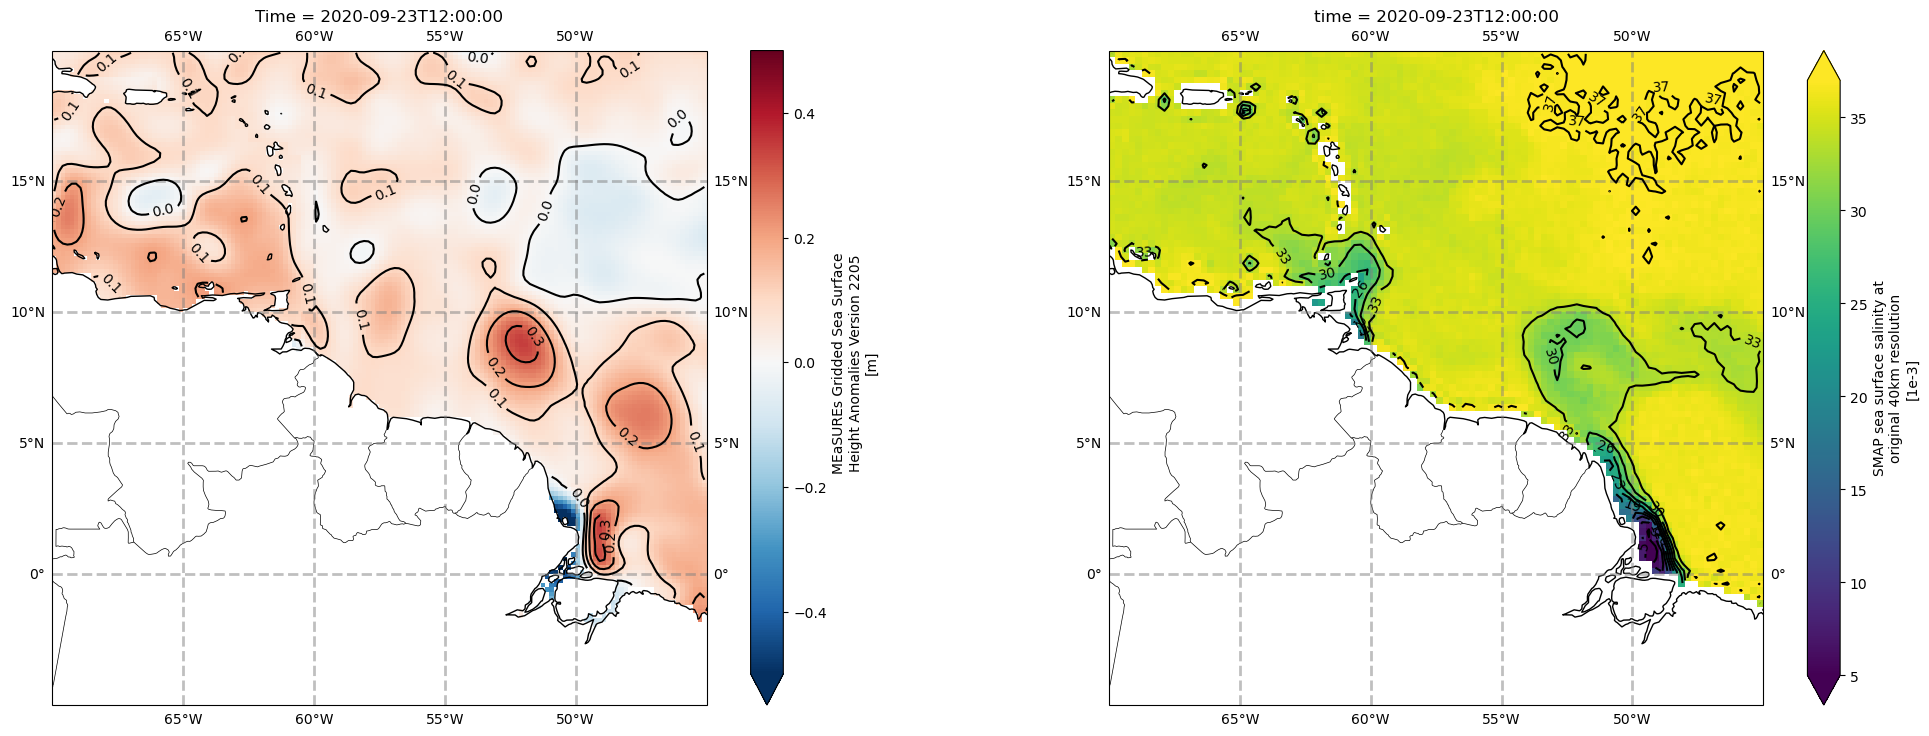

In [20]:
# initialize figure
fig, (ax1, ax2) = plt.subplots(1,2,
                               subplot_kw = {'projection':ccrs.PlateCarree()},
                               figsize=(25, 8.5))
# add features to subplots
for ax in (ax1, ax2):
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    gl = ax.gridlines(
        draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--'
    )
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())

# plot sla
levs_sla = np.linspace(0,0.5,6)
fmt_sla = '%1.1f'
sla_subset_plot.plot(ax= ax1,vmin=-0.5, vmax=0.5, cmap ='RdBu_r', transform=ccrs.PlateCarree())
cs = sla_subset_plot.squeeze().plot.contour(ax= ax1,levels=levs_sla,colors='k')
ax1.clabel(cs, levs_sla, fmt=fmt_sla, inline=True, fontsize=10)

# plot sss
levs_sss = np.linspace(5,37,10)
fmt_sss = '%1.0f'
sss_subset_plot.plot(ax= ax2,vmin=5, vmax=37, transform=ccrs.PlateCarree())
cs = sss_subset_plot.squeeze().plot.contour(ax= ax2,levels=levs_sss,colors='k')
ax1.clabel(cs, levs_sss, fmt=fmt_sss, inline=True, fontsize=10)
plt.savefig("subplots.png",dpi=100)

Great; with the maps side-by-side, it's easier to understand the features. In the salinity map, we can see the freshwater discharge from the Orinoco and Amazon Rivers, close to the coast, at about 61°W,9°N and -48°W,0°, respectively. In addition, we can see a somewhat circular fresher water feature between about 50°W-55°W and 5°N-10°N. The location of this feature coincides with the location of the high circular sea surface height anomaly contours, strenghtening our hypothesis that it's a North Brazil Current Ring transporting freshwater from the Amazon River to the Caribbean. To the right, one can see the higher salinity values in a concave configuration, coinciding with the location of other circular sea surface height anomaly contours, suggesting this is a signature of the North Brazil Current retroflection, bringing salty water from the Equatorial Atlantic. For more information on this process, see [this article](https://bg.copernicus.org/articles/19/2969/2022/).

## Saving the data

Remember: we have done all this visualization without downloading one single data file! That's one of the best functionalities of xarray, the ability of looking at the data with "no strings attached", so you can only download once you know that dataset will work for you.

Now that we've seen that the subset DataArrays have interesting features, we may want to download them to our local machines, so we can analyze them further. That's very easy to do with xarray, by saving it in netCDF format. Here we build some filenames to use to save the DataArrays, but of course we could use any filename.

One very important thing to notice is that the saved files will contain the attributes we assigned from the original Dataset. This is necessary for reproducibility, so other people can build on your work, or even future you can have access to details of the data.

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Here we leave the saving commands commented, because if you continuously save files you can run out of storage. So be mindful when saving files!
</div>

In [22]:
sss_filename = sss_subset_plot.attrs['standard_name'] + ".nc"
sla_filename = sla_subset_plot.attrs['standard_name'] + ".nc"

# saving files - be careful here so you won't run out of storage!
# sss_subset_plot.to_netcdf(sss_filename)
# sla_subset_plot.to_netcdf(sla_filename)

---

## Summary
In this notebook we were able to leverage the `earthaccess` library to access large datasets with `xarrray` and visualize them with `matplotlib` and `cartopy`. We learned the advantages of accessing data programatically, including promoting science reproducibility. We were able to subset data and then, only when we identified data that would be of interest, download it. That is specially advantageous for cases with limited available storage or limited computing capacity.


### What's next?
[Nasa Earthdata Search](https://search.earthdata.nasa.gov) has various types of data, in different formats and from different platforms. The user is certainly encouraged to play around with other types of data, to become more comfortable with this tool.

The `earthaccess` library is a wrap around the NASA Earth Science APIs. With the knowledge from this notebook, the user may understand bettter the structure of metadata in APIs and feel more comfortable accessing data via APIs from other sources, such as [NCEI](https://www.ncei.noaa.gov/support/access-data-service-api-user-documentation) and [USGS](https://data.usgs.gov/datacatalog/api/docs). 

## Resources and references

* [Earthdata Search web application](https://search.earthdata.nasa.gov/)
* [info on earthaccess](https://www.earthdata.nasa.gov/learn/blog/earthaccess)
* [earthaccess Github repository](https://github.com/nsidc/earthaccess)
* [earthaccess documentation page](https://earthaccess.readthedocs.io/en/latest/)
* [Earthdata cloud clinic](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/tutorials/Earthdata-cloud-clinic.html)
* [USGS Science Data Catalog API Documentation](https://data.usgs.gov/datacatalog/api/docs#/Harvest/read_harvested_files_harvest_files_get)
* [NCEI API user documentation](https://www.ncei.noaa.gov/support/access-data-service-api-user-documentation)
* [Intro to cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html)
* [Matplotlib basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html)
* [netCDF and CF: the basics](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html)
* [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html)
* [Article on North Brazil Current Rings](https://bg.copernicus.org/articles/19/2969/2022/)

 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!